Setup the environment variables

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.functions import col, avg
import seaborn as sns
spark = SparkSession \
    .builder \
    .appName("Singapore-Airbnb-B") \
    .master("spark://10.10.28.10:7077") \
    .config("spark.cores.max", 10) \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-04-10 22:26:24,904 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-04-10 22:26:25,831 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2022-04-10 22:26:25,832 WARN util.Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
2022-04-10 22:26:25,832 WARN util.Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [2]:
file_loc = "/user/team4/listings.csv"
airbnb_schema = spark.read.csv(file_loc, inferSchema=True, header=True, multiLine=True, quote='"', escape='"')

In [3]:
airbnb_schema.show()
print("Total number of records in the dataset - ", airbnb_schema.count())

+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-------+
|    id|                name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|license|
+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-------+
| 50646|Pleasant Room alo...| 227796|  Sujatha|     Central Region|  Bukit Timah| 1.33432|103.78521|   Private room|   80|            90|               18| 2014-12-26|             0.19|                       

Total number of records in the dataset -  3672


**8. Print the dataset schema to understand the type of data we are dealing with.**

In [4]:
airbnb_schema.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- number_of_reviews_ltm: integer (nullable = true)
 |-- license: string (nullable = true)



In [5]:
# Check for count of null values in each column of the dataframe.
print("Count of null values for each feature: ")
for col in airbnb_schema.columns:
  print(col, ": ", airbnb_schema.where(airbnb_schema[col].isNull()).count())

Count of null values for each feature: 


id :  0
name :  0
host_id :  0
host_name :  11
neighbourhood_group :  0
neighbourhood :  0
latitude :  0
longitude :  0
room_type :  0
price :  0
minimum_nights :  0
number_of_reviews :  0
last_review :  1628
reviews_per_month :  1628
calculated_host_listings_count :  0
availability_365 :  0
number_of_reviews_ltm :  0
license :  3019


**We see that there are a lot of nulls by observing the first 20 rows of the dataset above. So, we checked the count of null values in each column of the dataset.**

**10. Drop some columns which are not important for analyzing the data.**

In [6]:
airbnb_schema = airbnb_schema.drop("id", "host_name", "last_review")

**11. Clean the null values from review_per_month column . We will replace all the null values with zero as "null" reviews_per_month means there were 0 reviews.**

In [7]:
airbnb_schema = airbnb_schema.na.fill(0, ["reviews_per_month"])
print("Number of nulls after cleanup in column 'reviews_per_month' - ")
airbnb_schema.where(airbnb_schema['reviews_per_month'].isNull()).count()

Number of nulls after cleanup in column 'reviews_per_month' - 


0

**12. Analyze the host id field.** 

Count the number of listings for each host ID.

Sort the results in descending order, so we can see the top 20 hosts.

In [8]:
host_id_schema = airbnb_schema.groupBy(airbnb_schema["host_id"]).count()
host_id_schema.orderBy(host_id_schema["count"].desc()).show()

+---------+-----+
|  host_id|count|
+---------+-----+
|138649185|  199|
|156409670|  179|
| 66406177|  138|
|238891646|  126|
|  2413412|   86|
| 23722617|   77|
|  8948251|   65|
|108773366|   59|
| 23336011|   55|
|101145755|   51|
| 97878860|   50|
| 45877399|   47|
| 32798595|   45|
|201775246|   41|
| 24496358|   37|
| 68059127|   34|
|374499296|   33|
|148161755|   30|
| 20883050|   27|
|279311966|   20|
+---------+-----+
only showing top 20 rows



**The above analysis shows that the top host (host_id = 138649185) has 199 listings and also there is a good spread in the number of listings with each host.**

**We can confirm this finding by checking the 'calculated_host_listings_count' column which has a maximum value of 199.**

**13. Check the max value from calculated_host_listings_count column**

In [9]:
# Check the max value from calculated_host_listings_count column
from pyspark.sql import functions as F
airbnb_schema.agg(F.max(airbnb_schema["calculated_host_listings_count"])).show()

+-----------------------------------+
|max(calculated_host_listings_count)|
+-----------------------------------+
|                                199|
+-----------------------------------+



**14. Counting the number of unique listings:**

There are 3350 unique listings in the dataset.

In [10]:
airbnb_schema.select("name").distinct().count()

3350

**15. Distinct neighbourhood group count**

In [11]:
airbnb_schema.select("neighbourhood_group").distinct().count()

5

**16. Distinct neighbourhood group**

In [12]:
neighbourhood_group_data = airbnb_schema.groupby("neighbourhood_group").count()
neighbourhood_group_data.show()

+-------------------+-----+
|neighbourhood_group|count|
+-------------------+-----+
|        West Region|  269|
|     Central Region| 2909|
|       North Region|  105|
|        East Region|  249|
|  North-East Region|  140|
+-------------------+-----+



**17 Showing the above data as a pie chart to understand the division clearly.**

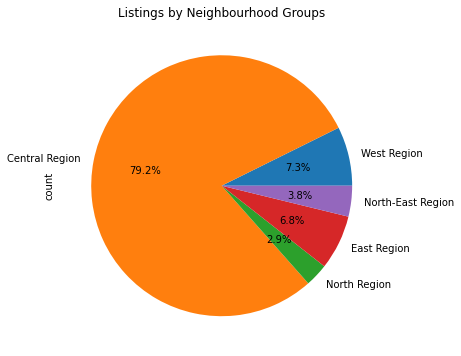

In [13]:
import pandas as pd
neighbourhood_group_data_pd = neighbourhood_group_data.toPandas()
neighbourhood_group_data_pd.index = neighbourhood_group_data_pd['neighbourhood_group']
plt = neighbourhood_group_data_pd.plot.pie(y='count', autopct='%1.1f%%', legend = False, title='Listings by Neighbourhood Groups', figsize=(16,6))


**18. Distinct neighbourhood count**

In [14]:
airbnb_schema.select("neighbourhood").distinct().count()

44

**19. Distinct neighbourhood**

In [15]:
airbnb_schema.groupby("neighbourhood").count().show()

+--------------------+-----+
|       neighbourhood|count|
+--------------------+-----+
|             Geylang|  340|
|                Tuas|    1|
|Central Water Cat...|   12|
|         Jurong West|   59|
|        Sungei Kadut|    1|
|              Rochor|  270|
|             Orchard|   80|
|         Bukit Merah|  178|
|               Bedok|  186|
|Western Water Cat...|    3|
|             Tanglin|   90|
|              Newton|   57|
|           Woodlands|   44|
|        Lim Chu Kang|    1|
|         Bukit Timah|   56|
|        River Valley|  149|
|          Queenstown|  143|
|        Marina South|    3|
|           Serangoon|   35|
|             Kallang|  405|
+--------------------+-----+
only showing top 20 rows



In [16]:
from pyspark.sql import functions
from pyspark.sql.functions import col, avg
airbnb_schema.groupby("neighbourhood").count().sort(col("count").desc()).show(5)

+-------------+-----+
|neighbourhood|count|
+-------------+-----+
|      Kallang|  405|
|      Geylang|  340|
|Downtown Core|  317|
|       Outram|  309|
|       Rochor|  270|
+-------------+-----+
only showing top 5 rows



**21. Analysis of availability of apartments.**

In [17]:
avail_df = airbnb_schema.groupby("availability_365").count().sort(col("availability_365").asc())
avail_df.show()

+----------------+-----+
|availability_365|count|
+----------------+-----+
|               0|  605|
|               1|    9|
|               2|    9|
|               3|    3|
|               4|    2|
|               5|    3|
|               6|    1|
|               7|    1|
|               8|    1|
|               9|    1|
|              10|    5|
|              11|    1|
|              12|    1|
|              14|    1|
|              15|    4|
|              16|    2|
|              18|    3|
|              19|    2|
|              20|    2|
|              22|    3|
+----------------+-----+
only showing top 20 rows



**22. Distinct host id**

In [18]:
airbnb_schema.select("host_id").distinct().count()

1044

**23. Number of apartments under different room type**

In [19]:
# Number of apartments under different room type
room_type_data = airbnb_schema.where(airbnb_schema.room_type.isin("Private room","Entire home/apt","Shared room")).groupBy(airbnb_schema["room_type"]).count().sort(col("room_type").desc())
room_type_data.show()

+---------------+-----+
|      room_type|count|
+---------------+-----+
|    Shared room|  147|
|   Private room| 1693|
|Entire home/apt| 1670|
+---------------+-----+



**24. Showing a general preference based on the room types. As we can see, most people prefer an Entire home/apt followed by Private Room and very few Shared rooms**

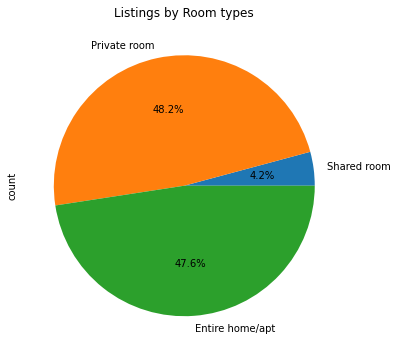

In [20]:
import pandas as pd
room_type_data_pd = room_type_data.toPandas()
room_type_data_pd.index = room_type_data_pd['room_type']
plt = room_type_data_pd.plot.pie(y='count', autopct='%1.1f%%', legend = False, title='Listings by Room types', figsize=(16,6))

**25. Combining room_type with neighbourhoodt**

In [21]:
neigh_room_type_schema = airbnb_schema.select(airbnb_schema["neighbourhood"], airbnb_schema["room_type"]).show()

+-------------+---------------+
|neighbourhood|      room_type|
+-------------+---------------+
|  Bukit Timah|   Private room|
|     Tampines|   Private room|
|     Tampines|   Private room|
|     Tampines|   Private room|
|  Bukit Merah|   Private room|
|  Bukit Merah|   Private room|
|       Newton|   Private room|
|  Bukit Merah|   Private room|
|  Bukit Merah|   Private room|
|  Bukit Merah|   Private room|
|     Tampines|   Private room|
|      Geylang|   Private room|
|       Newton|   Private room|
|       Newton|   Private room|
| River Valley|   Private room|
|     Tampines|   Private room|
|  Bukit Timah|Entire home/apt|
|     Tampines|   Private room|
|       Rochor|   Private room|
|  Bukit Timah|   Private room|
+-------------+---------------+
only showing top 20 rows



**26. Below table shows room type by neighbourhood group**

In [22]:
# room type by neighbourhood group.
neighbourhoodgrp_roomtype = airbnb_schema.select(airbnb_schema["neighbourhood_group"], airbnb_schema["room_type"]).groupBy("neighbourhood_group", "room_type").count()
neighbourhoodgrp_roomtype.show()

+-------------------+---------------+-----+
|neighbourhood_group|      room_type|count|
+-------------------+---------------+-----+
|        West Region|Entire home/apt|  107|
|        East Region|     Hotel room|    3|
|  North-East Region|Entire home/apt|   33|
|     Central Region|    Shared room|  126|
|        East Region|Entire home/apt|   51|
|       North Region|   Private room|   90|
|        West Region|    Shared room|   10|
|  North-East Region|   Private room|  104|
|        East Region|    Shared room|    6|
|       North Region|    Shared room|    2|
|  North-East Region|    Shared room|    3|
|     Central Region|   Private room| 1158|
|        East Region|   Private room|  189|
|     Central Region|     Hotel room|  159|
|     Central Region|Entire home/apt| 1466|
|       North Region|Entire home/apt|   13|
|        West Region|   Private room|  152|
+-------------------+---------------+-----+



**27. Showing the distribution of room types based on the neighbourhood group. From this we can get an idea of what room type are most popular in respective neighbourhood group. This is very important data for someone who would like to setup a new listing or update an existing one.**

<AxesSubplot:xlabel='neighbourhood_group'>

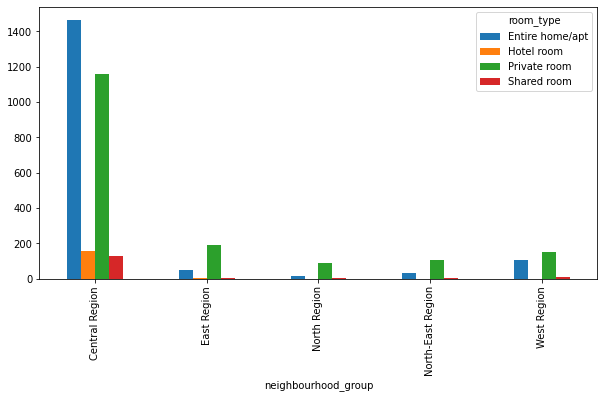

In [23]:
import pandas as pd
neighbourhoodgrp_roomtype_pd = neighbourhoodgrp_roomtype.toPandas()
pd.pivot_table(neighbourhoodgrp_roomtype_pd, index='neighbourhood_group', columns='room_type', values='count').plot.bar(figsize=(10,5))


**28. Combining neighbourhood with neighbourhood group**

In [24]:
nei_group_nei_schema = airbnb_schema.select(airbnb_schema["neighbourhood_group"], airbnb_schema["neighbourhood"])
nei_group_nei_schema.sort(col("neighbourhood_group").desc()).show()

+-------------------+-------------+
|neighbourhood_group|neighbourhood|
+-------------------+-------------+
|        West Region|  Jurong West|
|        West Region|  Jurong West|
|        West Region|  Jurong West|
|        West Region|Choa Chu Kang|
|        West Region|  Jurong East|
|        West Region|  Jurong East|
|        West Region|  Jurong East|
|        West Region|     Clementi|
|        West Region|  Jurong East|
|        West Region|  Bukit Batok|
|        West Region|  Bukit Batok|
|        West Region|  Bukit Batok|
|        West Region|  Bukit Batok|
|        West Region|  Jurong West|
|        West Region|Choa Chu Kang|
|        West Region|  Jurong West|
|        West Region|  Jurong West|
|        West Region|  Bukit Batok|
|        West Region|Bukit Panjang|
|        West Region|  Jurong West|
+-------------------+-------------+
only showing top 20 rows



**29. Find the popular neighbourhood groups:**

Popular neighbourhood_groups are Central Region, West Region, East Region, North-East Region, North Region

In [25]:

nei_group_nei_schema.groupBy("neighbourhood_group").count().sort(col("count").desc()).show()


+-------------------+-----+
|neighbourhood_group|count|
+-------------------+-----+
|     Central Region| 2909|
|        West Region|  269|
|        East Region|  249|
|  North-East Region|  140|
|       North Region|  105|
+-------------------+-----+



Above we check which neighbourhood group is the most popular based on the number of listings in that group. Also, how the count varies for other neighbourhood groups. **The result shows that Central Region is the most popular neighbourhood group for people**.

**30. Number of neighbourhood in popular neighbourhood_groups**


In [26]:
manhattan_nei = nei_group_nei_schema.where(nei_group_nei_schema.neighbourhood_group.like("Central Region")).groupBy("neighbourhood").count().sort(col("count").desc())
brooklyn_nei =  nei_group_nei_schema.where(nei_group_nei_schema.neighbourhood_group.like("West Region")).groupBy("neighbourhood").count().sort(col("count").desc())
queens_nei =  nei_group_nei_schema.where(nei_group_nei_schema.neighbourhood_group.like("East Region")).groupBy("neighbourhood").count().sort(col("count").desc())
bronx_nei =  nei_group_nei_schema.where(nei_group_nei_schema.neighbourhood_group.like("North-East Region")).groupBy("neighbourhood").count().sort(col("count").desc())
north_nei =  nei_group_nei_schema.where(nei_group_nei_schema.neighbourhood_group.like("North Region")).groupBy("neighbourhood").count().sort(col("count").desc())


**31. Combining neighbourhood_group, neighbourhood and room_type**

In [27]:
neigh_group_neigh_room_type_schema = airbnb_schema.select("neighbourhood_group", "neighbourhood", "room_type")

**32. Distribution of rooms in various neighbourhood in Central Region.**

In [28]:
print("Showing distribution for room_type = 'Private room' in Central Region")
manhattan_nei_private = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="Central Region") & (col("room_type")=="Private room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Shared room' in Central Region")
manhattan_nei_shared = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group").like("Central Region%")) & (col("room_type")=="Shared room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Entire home/apt' in Central Region")
manhattan_nei_entire_home = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="Central Region") & (col("room_type")=="Entire home/apt")).groupBy("neighbourhood").count().sort(col("count").desc()).show()


Showing distribution for room_type = 'Private room' in Central Region
+----------------+-----+
|   neighbourhood|count|
+----------------+-----+
|         Kallang|  213|
|         Geylang|  158|
|          Outram|  127|
|   Downtown Core|  123|
|          Rochor|  119|
|     Bukit Merah|   68|
|          Novena|   57|
|      Queenstown|   46|
|     Bukit Timah|   37|
|    River Valley|   34|
|          Newton|   31|
| Singapore River|   27|
|   Marine Parade|   23|
|          Bishan|   23|
|         Tanglin|   20|
|       Toa Payoh|   17|
|         Orchard|   16|
|          Museum|   10|
|Southern Islands|    6|
|    Marina South|    3|
+----------------+-----+

Showing distribution for room_type = 'Shared room' in Central Region
+---------------+-----+
|  neighbourhood|count|
+---------------+-----+
|         Rochor|   44|
|        Kallang|   37|
|     Queenstown|    8|
|         Outram|    8|
|Singapore River|    8|
|        Geylang|    6|
|  Downtown Core|    5|
|      Toa Payoh|   

**33. Distribution of rooms in various neighbourhood in West Region.**

In [29]:

print("Showing distribution for room_type = 'Private room' in West Region")
brooklyn_nei_private = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="West Region") & (col("room_type")=="Private room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Shared room' in West Region")
brooklyn_nei_shared = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group").like("West Region")) & (col("room_type")=="Shared room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Entire home/apt' in West Region")
brooklyn_nei_entire_home = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="West Region") & (col("room_type")=="Entire home/apt")).groupBy("neighbourhood").count().sort(col("count").desc()).show()


Showing distribution for room_type = 'Private room' in West Region
+--------------------+-----+
|       neighbourhood|count|
+--------------------+-----+
|         Jurong West|   52|
|         Bukit Batok|   26|
|            Clementi|   22|
|         Jurong East|   21|
|       Choa Chu Kang|   14|
|       Bukit Panjang|   14|
|Western Water Cat...|    2|
|             Pioneer|    1|
+--------------------+-----+

Showing distribution for room_type = 'Shared room' in West Region
+-------------+-----+
|neighbourhood|count|
+-------------+-----+
|  Jurong East|    4|
|     Clementi|    3|
|  Jurong West|    1|
|  Bukit Batok|    1|
|Choa Chu Kang|    1|
+-------------+-----+

Showing distribution for room_type = 'Entire home/apt' in West Region
+--------------------+-----+
|       neighbourhood|count|
+--------------------+-----+
|            Clementi|   47|
|         Jurong East|   46|
|         Jurong West|    6|
|         Bukit Batok|    4|
|       Choa Chu Kang|    2|
|                

**34. Distribution of rooms in various neighbourhood in East Region.**

In [30]:
# 
print("Showing distribution for room_type = 'Private room' in East Region")
queens_nei_private = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="East Region") & (col("room_type")=="Private room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Shared room' in East Region")
queens_nei_shared = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="East Region") & (col("room_type")=="Shared room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Entire home/apt' in East Region")
queens_nei_entire_home = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="East Region") & (col("room_type")=="Entire home/apt")).groupBy("neighbourhood").count().sort(col("count").desc()).show()


Showing distribution for room_type = 'Private room' in East Region
+-------------+-----+
|neighbourhood|count|
+-------------+-----+
|        Bedok|  144|
|     Tampines|   26|
|    Pasir Ris|   19|
+-------------+-----+

Showing distribution for room_type = 'Shared room' in East Region
+-------------+-----+
|neighbourhood|count|
+-------------+-----+
|        Bedok|    3|
|    Pasir Ris|    2|
|     Tampines|    1|
+-------------+-----+

Showing distribution for room_type = 'Entire home/apt' in East Region
+-------------+-----+
|neighbourhood|count|
+-------------+-----+
|        Bedok|   36|
|    Pasir Ris|   12|
|     Tampines|    3|
+-------------+-----+



**35. Distribution of rooms in various neighbourhood in North-East Region.**

In [31]:
print("Showing distribution for room_type = 'Private room' in North-East Region")
bronx_nei_private = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="North-East Region") & (col("room_type")=="Private room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Shared room' in North-East Region")
bronx_nei_shared = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="North-East Region") & (col("room_type")=="Shared room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Entire home/apt' in North-East Region")
bronx_nei_entire_home = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="North-East Region") & (col("room_type")=="Entire home/apt")).groupBy("neighbourhood").count().sort(col("count").desc()).show()


Showing distribution for room_type = 'Private room' in North-East Region
+-------------+-----+
|neighbourhood|count|
+-------------+-----+
|    Serangoon|   28|
|      Hougang|   24|
|   Ang Mo Kio|   24|
|     Sengkang|   16|
|      Punggol|   12|
+-------------+-----+

Showing distribution for room_type = 'Shared room' in North-East Region
+-------------+-----+
|neighbourhood|count|
+-------------+-----+
|      Punggol|    1|
|     Sengkang|    1|
|   Ang Mo Kio|    1|
+-------------+-----+

Showing distribution for room_type = 'Entire home/apt' in North-East Region
+-------------+-----+
|neighbourhood|count|
+-------------+-----+
|      Hougang|   19|
|    Serangoon|    7|
|      Punggol|    4|
|     Sengkang|    2|
|   Ang Mo Kio|    1|
+-------------+-----+



**36. Distribution of rooms in various neighbourhood in North Region.**

In [32]:
print("Showing distribution for room_type = 'Private room' in North Region")
bronx_nei_private = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="North Region") & (col("room_type")=="Private room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Shared room' in North Region")
bronx_nei_shared = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="North Region") & (col("room_type")=="Shared room")).groupBy("neighbourhood").count().sort(col("count").desc()).show()
print("Showing distribution for room_type = 'Entire home/apt' in North Region")
bronx_nei_entire_home = neigh_group_neigh_room_type_schema.where((col("neighbourhood_group")=="North Region") & (col("room_type")=="Entire home/apt")).groupBy("neighbourhood").count().sort(col("count").desc()).show()


Showing distribution for room_type = 'Private room' in North Region
+--------------------+-----+
|       neighbourhood|count|
+--------------------+-----+
|           Woodlands|   40|
|           Sembawang|   25|
|              Yishun|   18|
|Central Water Cat...|    5|
|              Mandai|    2|
+--------------------+-----+

Showing distribution for room_type = 'Shared room' in North Region
+-------------+-----+
|neighbourhood|count|
+-------------+-----+
| Sungei Kadut|    1|
|       Yishun|    1|
+-------------+-----+

Showing distribution for room_type = 'Entire home/apt' in North Region
+--------------------+-----+
|       neighbourhood|count|
+--------------------+-----+
|Central Water Cat...|    7|
|           Woodlands|    4|
|        Lim Chu Kang|    1|
|           Sembawang|    1|
+--------------------+-----+



**37. Total average price of various room types**

In [33]:
nei_group_nei_room_price_schema = airbnb_schema.select("neighbourhood_group", "neighbourhood", "room_type", "price")
nei_group_nei_room_price_schema.agg(avg(col("price")).alias("Total average price")).show()
# Total average price of private room.
nei_group_nei_room_price_schema.where(col("room_type")=="Private room").agg(avg(col("price")).alias("Total average price of private room")).show()
# Total average price of shared room.
nei_group_nei_room_price_schema.where(col("room_type")=="Shared room").agg(avg(col("price")).alias("Total average price of shared room")).show()
# Total average price of entire home/apt.
nei_group_nei_room_price_schema.where(col("room_type")=="Entire home/apt").agg(avg(col("price")).alias("Total average price of entire home room")).show()

+-------------------+
|Total average price|
+-------------------+
| 209.50054466230938|
+-------------------+

+-----------------------------------+
|Total average price of private room|
+-----------------------------------+
|                 139.57944477259304|
+-----------------------------------+

+----------------------------------+
|Total average price of shared room|
+----------------------------------+
|                108.99319727891157|
+----------------------------------+

+---------------------------------------+
|Total average price of entire home room|
+---------------------------------------+
|                     291.75748502994014|
+---------------------------------------+



**37. Average price of various room types in Central Region**

In [34]:
manhattan_nei_private = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Central Region") & (col("room_type")=="Private room")).agg(avg(col("price")).alias("Average price of private room in Central Region")).show()
manhattan_nei_shared = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Central Region") & (col("room_type")=="Shared room")).agg(avg(col("price")).alias("Average price of shared room in Central Region")).show()
manhattan_nei_entire_home = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="Central Region") & (col("room_type")=="Entire home/apt")).agg(avg(col("price")).alias("Average price of entire home/apt in Central Region")).show()


+-----------------------------------------------+
|Average price of private room in Central Region|
+-----------------------------------------------+
|                             154.34455958549222|
+-----------------------------------------------+

+----------------------------------------------+
|Average price of shared room in Central Region|
+----------------------------------------------+
|                             104.4920634920635|
+----------------------------------------------+

+--------------------------------------------------+
|Average price of entire home/apt in Central Region|
+--------------------------------------------------+
|                                 284.2230559345157|
+--------------------------------------------------+



**38. Average price of various room types in West**

In [35]:
brooklyn_nei_private = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="West Region") & (col("room_type")=="Private room")).agg(avg(col("price")).alias("Average price of private room in West Region")).show()
brooklyn_nei_shared = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="West Region") & (col("room_type")=="Shared room")).agg(avg(col("price")).alias("Average price of shared room in West Region")).show()
brooklyn_nei_entire_home = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="West Region") & (col("room_type")=="Entire home/apt")).agg(avg(col("price")).alias("Average price of entire home/apt in West Region")).show()


+--------------------------------------------+
|Average price of private room in West Region|
+--------------------------------------------+
|                           98.53947368421052|
+--------------------------------------------+

+-------------------------------------------+
|Average price of shared room in West Region|
+-------------------------------------------+
|                                       48.3|
+-------------------------------------------+

+-----------------------------------------------+
|Average price of entire home/apt in West Region|
+-----------------------------------------------+
|                             333.21495327102804|
+-----------------------------------------------+



**39. Average price of various room types in East Region**

In [36]:
# Average price of various room types in various (popular) neighbourhood groups
# In Queens.
queens_nei_private = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="East Region") & (col("room_type")=="Private room")).agg(avg(col("price")).alias("Average price of private room in East Region")).show()
queens_nei_shared = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="East Region") & (col("room_type")=="Shared room")).agg(avg(col("price")).alias("Average price of shared room in East Region")).show()
queens_nei_entire_home = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="East Region") & (col("room_type")=="Entire home/apt")).agg(avg(col("price")).alias("Average price of entire home/apt in East Region")).show()


+--------------------------------------------+
|Average price of private room in East Region|
+--------------------------------------------+
|                          125.75132275132275|
+--------------------------------------------+

+-------------------------------------------+
|Average price of shared room in East Region|
+-------------------------------------------+
|                          284.8333333333333|
+-------------------------------------------+

+-----------------------------------------------+
|Average price of entire home/apt in East Region|
+-----------------------------------------------+
|                             391.03921568627453|
+-----------------------------------------------+



**40. Average price of various room types in North-East Region**

In [37]:
 # Average price of various room types in various (popular) neighbourhood groups
# In Bronx.
bronx_nei_private = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="North-East Region") & (col("room_type")=="Private room")).agg(avg(col("price")).alias("Average price of private room in North-East Region")).show()
bronx_nei_shared = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="North-East Region") & (col("room_type")=="Shared room")).agg(avg(col("price")).alias("Average price of shared room in North-East Region")).show()
bronx_nei_entire_home = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="North-East Region") & (col("room_type")=="Entire home/apt")).agg(avg(col("price")).alias("Average price of entire home/apt in North-East Region")).show()


+--------------------------------------------------+
|Average price of private room in North-East Region|
+--------------------------------------------------+
|                                100.01923076923077|
+--------------------------------------------------+

+-------------------------------------------------+
|Average price of shared room in North-East Region|
+-------------------------------------------------+
|                               108.66666666666667|
+-------------------------------------------------+

+-----------------------------------------------------+
|Average price of entire home/apt in North-East Region|
+-----------------------------------------------------+
|                                    340.3636363636364|
+-----------------------------------------------------+



**40. Average price of various room types in North Region**

In [38]:
 # Average price of various room types in various (popular) neighbourhood groups
# In Bronx.
bronx_nei_private = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="North Region") & (col("room_type")=="Private room")).agg(avg(col("price")).alias("Average price of private room in North Region")).show()
bronx_nei_shared = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="North Region") & (col("room_type")=="Shared room")).agg(avg(col("price")).alias("Average price of shared room in North Region")).show()
bronx_nei_entire_home = nei_group_nei_room_price_schema.where((col("neighbourhood_group")=="North Region") & (col("room_type")=="Entire home/apt")).agg(avg(col("price")).alias("Average price of entire home/apt in North Region")).show()


+---------------------------------------------+
|Average price of private room in North Region|
+---------------------------------------------+
|                            93.66666666666667|
+---------------------------------------------+

+--------------------------------------------+
|Average price of shared room in North Region|
+--------------------------------------------+
|                                       169.0|
+--------------------------------------------+

+------------------------------------------------+
|Average price of entire home/apt in North Region|
+------------------------------------------------+
|                               287.3076923076923|
+------------------------------------------------+



**41. Total frequency of nights people stay in all the neighbourhood groups**

In [39]:

nei_group_nei_min_nights_schema = airbnb_schema.select("neighbourhood_group", "neighbourhood", "minimum_nights")
nei_group_nei_min_nights_schema.na.drop(subset=["minimum_nights"]).groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()

+--------------+-----+
|minimum_nights|count|
+--------------+-----+
|             1|  806|
|             2|  196|
|             3|  157|
|             4|   62|
|             5|   84|
|             6|  452|
|             7|  234|
|             9|    4|
|            10|   36|
|            12|    2|
|            13|    3|
|            14|   50|
|            15|   19|
|            17|    1|
|            18|  156|
|            20|    6|
|            21|   19|
|            22|    1|
|            23|    1|
|            25|    4|
+--------------+-----+
only showing top 20 rows



**42. Total frequency of nights people stay in various (popular) neighbourhood groups**

In [40]:
# Total frequency of nights people stay in various (popular) neighbourhood groups
total_manhatten  = nei_group_nei_min_nights_schema.where((col("neighbourhood_group")=="Central Region")).count()
print(total_manhatten)
# In Manhattan.
manhattan_nei = nei_group_nei_min_nights_schema.where(col("neighbourhood_group")=="Central Region").groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()
# In Brooklyn
brooklyn_nei = nei_group_nei_min_nights_schema.where((col("neighbourhood_group")=="West Region")).groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()
# In Queens
queens_nei = nei_group_nei_min_nights_schema.where((col("neighbourhood_group")=="East Region")).groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()
# In Bronx
bronx_nei = nei_group_nei_min_nights_schema.where((col("neighbourhood_group")=="North-East Region")).groupBy("minimum_nights").count().sort(col("minimum_nights").asc()).show()


2909
+--------------+-----+
|minimum_nights|count|
+--------------+-----+
|             1|  646|
|             2|  146|
|             3|  127|
|             4|   52|
|             5|   61|
|             6|  421|
|             7|  185|
|             9|    3|
|            10|   30|
|            12|    1|
|            13|    3|
|            14|   44|
|            15|   10|
|            18|  155|
|            20|    6|
|            21|   18|
|            25|    3|
|            26|    4|
|            27|    2|
|            28|   29|
+--------------+-----+
only showing top 20 rows

+--------------+-----+
|minimum_nights|count|
+--------------+-----+
|             1|   37|
|             2|   18|
|             3|   10|
|             4|    1|
|             5|   12|
|             6|   16|
|             7|    9|
|            10|    5|
|            12|    1|
|            14|    4|
|            15|    3|
|            18|    1|
|            25|    1|
|            26|    3|
|            28|    1|
|  



**43. Let us check the 'number_of_reviews' column. We can find out the most popular listings based on the number of reviews.**

**Here we display top 20 records**

In [41]:
# 'number_of_reviews' column
from operator import attrgetter
data = airbnb_schema.rdd.top(20, attrgetter("number_of_reviews"))
most_reviewed_df = spark.sparkContext.parallelize(data).toDF()
most_reviewed_df.show()
most_reviewed_df.first()
most_reviewed_df.select("name", "neighbourhood_group", "neighbourhood", "room_type", "number_of_reviews").show()

+--------------------+---------+-------------------+----------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+---------------------+-------+
|                name|  host_id|neighbourhood_group|   neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|license|
+--------------------+---------+-------------------+----------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+---------------------+-------+
|Luxuriously Spaci...|  7642747|        East Region|           Bedok| 1.31936|103.91663|Entire home/apt|  139|            92|              369|             3.81|                             1|             239|                    0|   null|
|Spacious room nea...| 44793532|     Cen

**44. The average price for the listing for the 20 most reviewed listings is $118.15.**

In [42]:
most_reviewed_df.agg(avg("price")).show()

+----------+
|avg(price)|
+----------+
|    118.15|
+----------+



**45. We will now look at the latitude and longitude columns in the dataset. We can take a look at how the listings are distributed across geography. This will also tell us that which geographic region shows promise for starting a new listing.**

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

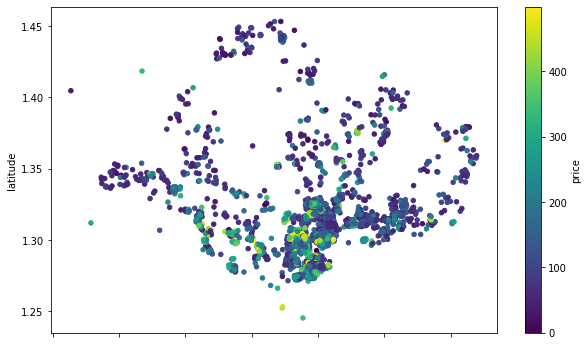

In [43]:
import pandas as pd
import matplotlib.pyplot as matp
airbnb_schema_pd = airbnb_schema.toPandas()
airbnb_schema_pd_trimmed = airbnb_schema_pd[airbnb_schema_pd['price'] < 500]
airbnb_schema_pd_trimmed.plot.scatter(x='longitude', y='latitude', c='price', cmap=matp.get_cmap('viridis'), figsize=(10,6))